## AI Text Detector

### Gerekli Kütüphaneleri yükleme

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, GlobalMaxPooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from gensim.models import Word2Vec
from IPython.display import display, HTML
import matplotlib.pyplot as plt

### Eğitim veri setini yükleme

In [3]:
train = pd.read_csv("VeriSeti1.csv")

### Ek veri setini yükleme ve birleştirme

In [4]:
additional_data = pd.read_csv("VeriSeti2.csv", sep=',')
additional_data = additional_data.rename(columns={'generated': 'etiket'})
additional_data = additional_data[["kaynak_metin"]]
additional_data.columns = ["metin"]
additional_data['metin'] = additional_data['metin'].str.replace('\n', '')
additional_data["etiket"] = 1

train = pd.concat([train, additional_data])

### Verileri özellik ve hedef değişkenlere ayırma

In [5]:
X = train['metin']
y = train['etiket']

### Kelime vektörlerini oluşturma (Word2Vec)

In [6]:
tokenized_text = X.apply(lambda x: x.split())
word2vec_model = Word2Vec(tokenized_text, vector_size=100, window=5, min_count=1, sg=1)
word_vectors = word2vec_model.wv

### Eğitim verisi metinleri kelime vektörlerine dönüştürme

In [7]:
max_length = 100 
def text_to_vector(text, max_length, word_vectors):
    tokens = text.split()
    vector = np.zeros((max_length, 100))
    for j, token in enumerate(tokens):
        if j == max_length:
            break
        if token in word_vectors:
            vector[j, :] = word_vectors[token]
    return vector

X_data = np.array([text_to_vector(text, max_length, word_vectors) for text in X])

### Eğitim ve test verisi olarak ayırma

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y, test_size=0.2, random_state=42)

### LSTM tabanlı RNN modelini oluşturma

In [10]:
model = Sequential([
    LSTM(64, input_shape=(max_length, 100), return_sequences=True),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

### Modeli derleme

In [11]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

### Erken durdurma kullanarak modeli eğitme

In [13]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2, callbacks=[early_stop])

Epoch 1/20
366/366 [==============================] - 33s 89ms/step - loss: 0.0236 - accuracy: 0.9928 - val_loss: 0.0529 - val_accuracy: 0.9809
Epoch 2/20
366/366 [==============================] - 32s 87ms/step - loss: 0.0144 - accuracy: 0.9961 - val_loss: 0.0497 - val_accuracy: 0.9833
Epoch 3/20
366/366 [==============================] - 32s 87ms/step - loss: 0.0144 - accuracy: 0.9951 - val_loss: 0.0431 - val_accuracy: 0.9894
Epoch 4/20
366/366 [==============================] - 32s 87ms/step - loss: 0.0082 - accuracy: 0.9974 - val_loss: 0.0413 - val_accuracy: 0.9894
Epoch 5/20
366/366 [==============================] - 32s 88ms/step - loss: 0.0055 - accuracy: 0.9984 - val_loss: 0.0392 - val_accuracy: 0.9908
Epoch 6/20
366/366 [==============================] - 32s 87ms/step - loss: 0.0089 - accuracy: 0.9973 - val_loss: 0.0454 - val_accuracy: 0.9880
Epoch 7/20
366/366 [==============================] - 32s 87ms/step - loss: 0.0055 - accuracy: 0.9985 - val_loss: 0.0420 - val_accuracy:

### Örnek metinleri ve etiketleri seçme

In [18]:
sample_indices = np.random.choice(train.index, size=5, replace=False)
sample_texts = train.loc[sample_indices, 'metin']
sample_labels = train.loc[sample_indices, 'etiket']

### Örnek metinleri kelime vektörlerine dönüştürme

In [19]:
sample_X = np.zeros((len(sample_texts), max_length, 100)) 
for i, tokens in enumerate(sample_texts.apply(lambda x: x.split())):
    for j, token in enumerate(tokens):
        if j == max_length:
            break
        if token in word_vectors:
            sample_X[i, j, :] = word_vectors[token]

### Örnek metinler üzerinde tahminler yapma

In [20]:
sample_preds_probs = model.predict(sample_X)
sample_preds = (sample_preds_probs > 0.5).astype(int).flatten()

1/1 [==============================] - 0s 85ms/step


### Tahmin sonuçları örnek metinler ile birlikte yazdırma

In [21]:
for text, label, pred, prob in zip(sample_texts, sample_labels, sample_preds, sample_preds_probs.flatten()):
    actual_label = 'Yapay Zeka Üretimi' if label == 1 else 'İnsan Yazımı'
    predicted_label = 'Yapay Zeka Üretimi' if pred == 1 else 'İnsan Yazımı'
    confidence = prob * 100 if pred == 1 else (1 - prob) * 100
    formatted_text = text.replace('\n', '<br>')
    display(HTML(f"<b>Metin:</b><br><p>{formatted_text}<br>"))
    display(HTML(f"<b>Gerçek Etiket:</b> {actual_label}"))
    display(HTML(f"<b>Tahmin Edilen:</b> {predicted_label} (%{confidence:.2f} oranında)<br>"))
    print("\n")


### Modelin performansını değerlendirme

In [22]:
loss, accuracy = model.evaluate(X_test, y_test)
accuracy_percent = accuracy * 100
print(f"Modelin doğruluğu: {accuracy_percent:.2f}%")

115/115 [==============================] - 5s 44ms/step - loss: 0.0283 - accuracy: 0.9910
Modelin doğruluğu: 99.10%


### Eğitim ve doğrulama kaybı ve doğruluğu grafiği

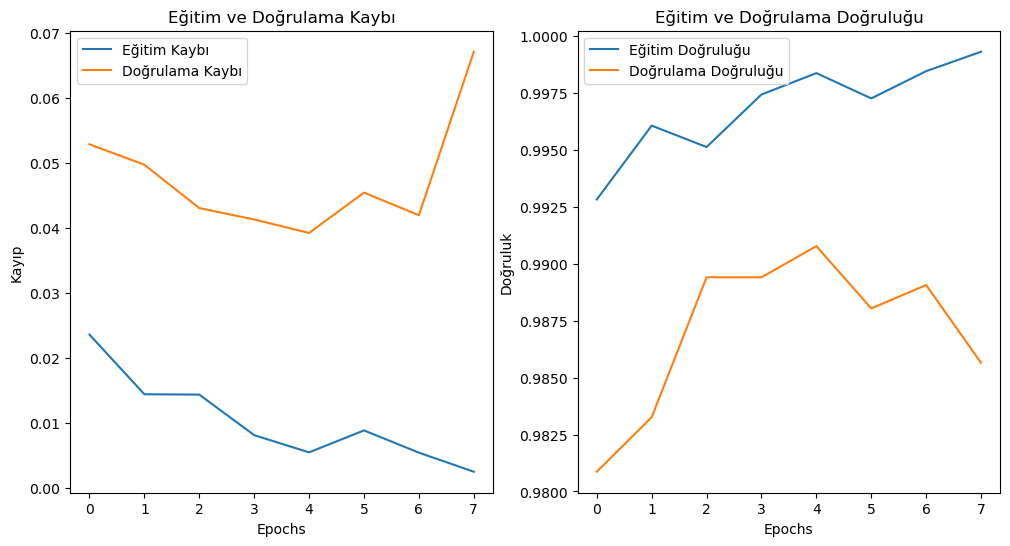

In [23]:
plt.figure(figsize=(12, 6))

# Kaybı çizme
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.title('Eğitim ve Doğrulama Kaybı')
plt.xlabel('Epochs')
plt.ylabel('Kayıp')
plt.legend()

# Doğruluğu çizme
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.title('Eğitim ve Doğrulama Doğruluğu')
plt.xlabel('Epochs')
plt.ylabel('Doğruluk')
plt.legend()

plt.show()


### Karışıklık matrisi oluşturma ve görselleştirme

115/115 [==============================] - 5s 41ms/step


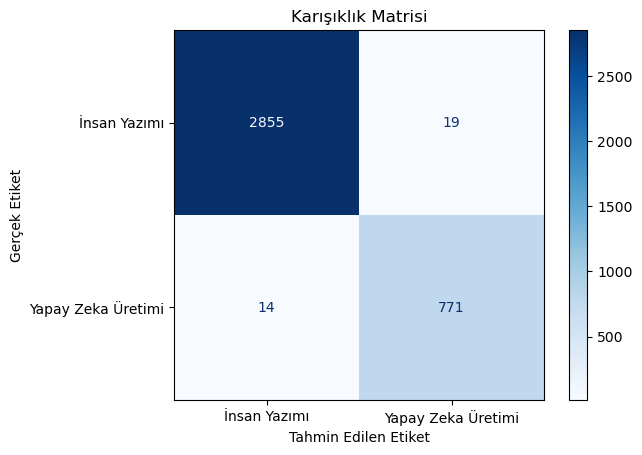

In [24]:
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['İnsan Yazımı', 'Yapay Zeka Üretimi'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Karışıklık Matrisi")
plt.xlabel("Tahmin Edilen Etiket")
plt.ylabel("Gerçek Etiket")
plt.show()


### Dışarıdan bir metni tanımlama ve insan yazımı mı yoksa yapay zeka üretimi mi olduğunu tespit etme

In [25]:
def predict_text_origin(text):
    text_vector = text_to_vector(text, max_length, word_vectors)
    text_vector = np.expand_dims(text_vector, axis=0)
    prediction_prob = model.predict(text_vector).flatten()[0]
    prediction = (prediction_prob > 0.5).astype(int)
    confidence = prediction_prob * 100 if prediction == 1 else (1 - prediction_prob) * 100
    return 'Yapay Zeka Üretimi' if prediction == 1 else 'İnsan Yazımı', confidence


### Metin dosyasını yükleme ve tahmin yapma

In [27]:
def predict_text_from_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    formatted_text = text.replace('\n', '<br>')  # Paragraf ayrımlarını koru
    prediction, confidence = predict_text_origin(text)
    
    display(HTML(f"<b>Metin:</b><br><p>{formatted_text}<br>"))
    display(HTML(f"<b>Tahmin Edilen:</b> {prediction} (%{confidence:.2f} oranında)<br>"))

file_path = "OrnekYapayZekaMetni.txt" 
predict_text_from_file(file_path) 

1/1 [==============================] - 0s 74ms/step
